In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style
import EOF_funcs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import GA_cofine
from pyts.image import RecurrencePlot
from  importlib  import reload

Reading the data, if surface.nc exists, read it, if not read the subset, select surface layer and replace NaN with interpolation in time. 

In [3]:
filenm='Data/surface_.nc'
try:
    print('Read:'+filenm)
    surface=xr.open_dataset(filenm)
except:
    print('Cannot find:'+filenm)
    print('Creating...')
    data=xr.open_dataset('byfjordenSubset.nc')
    data.close()
    surface=data.isel(depth=0).sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).isel(depth=0)
    surface['u']=surface.u.interpolate_na(dim='time')
    surface['v']=surface.v.interpolate_na(dim='time')
    surface.to_netcdf(filenm)



Read:Data/surface_.nc


Text(0.5, 1.0, 'Standard deviation v velocity')

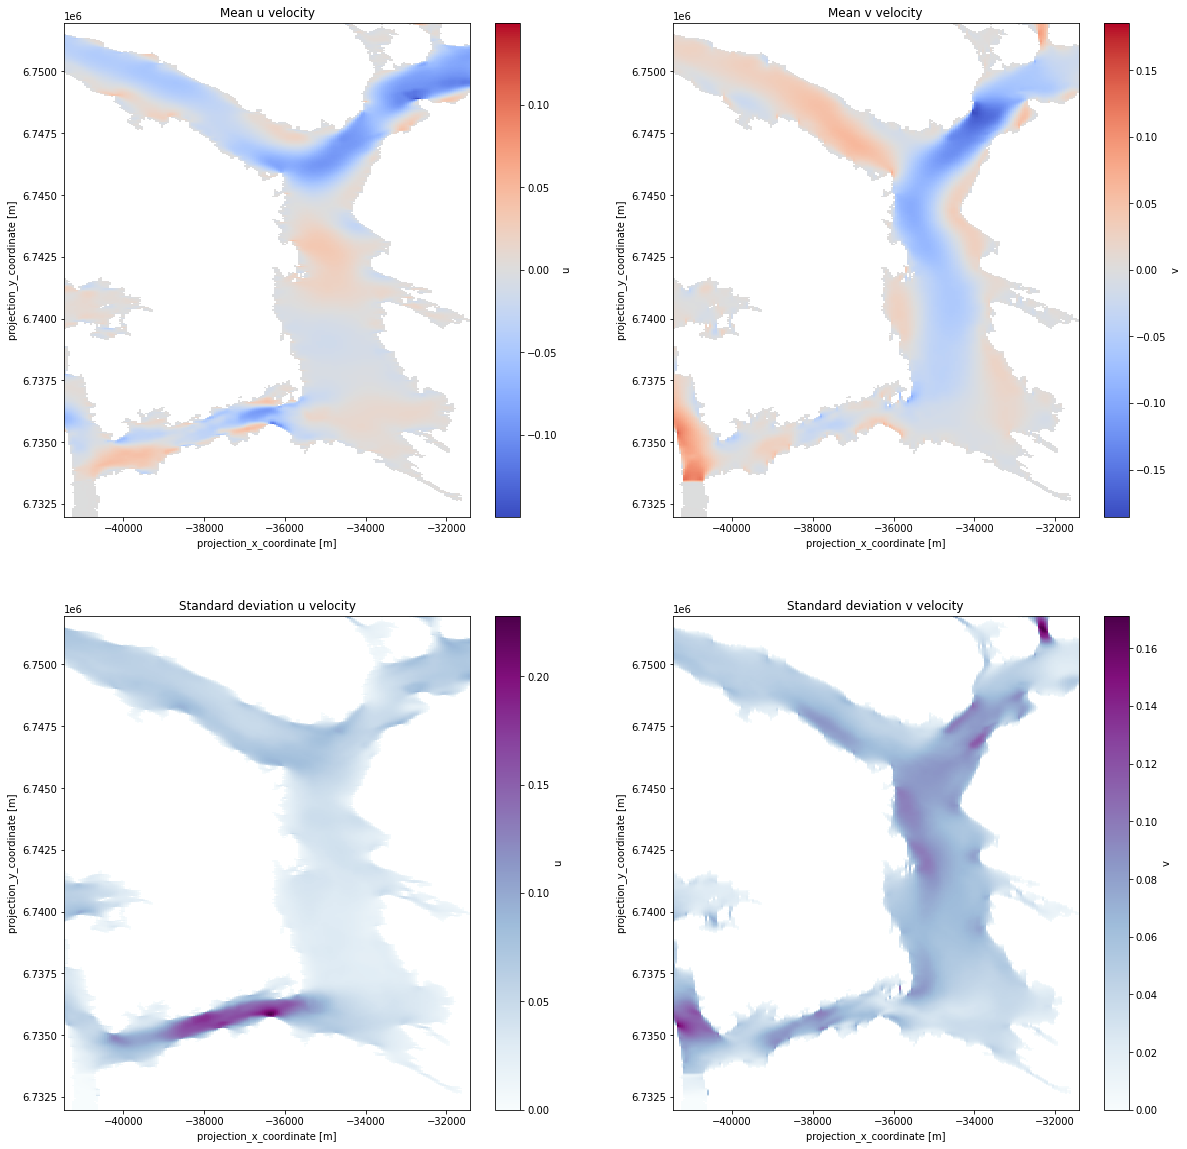

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
surface.u.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
surface.v.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
surface.u.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
surface.v.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


Text(0.5, 1.0, 'Correlation u and v')

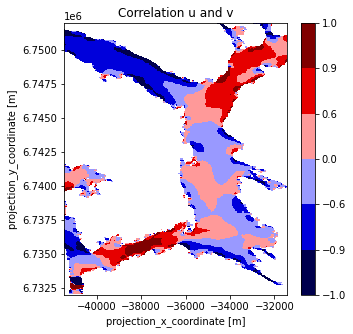

In [5]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
xr.corr(surface.u,surface.v,dim='time').plot(vmin=-1,vmax=1,levels=[-1,-0.9,-0.6,0,0.6,0.9,1],cmap='seismic',ax=axes)
axes.set_title('Correlation u and v')


In [4]:
surface

<xarray.Dataset>
Dimensions:           (time: 1501, Y: 400, X: 201)
Coordinates:
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
    depth             float32 ...
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, Y, X) float32 ...
    v                 (time, Y, X) float32 ...
    h                 (Y, X) float32 ...
    projection_stere  float32 ...
    land_binary_mask  (Y, X) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [5]:
u=(surface.u-surface.u.mean(dim='time')).stack(z=['Y','X'])
v=(surface.v-surface.v.mean(dim='time')).stack(z=['Y','X'])
mask=surface.land_binary_mask.stack(z=['Y','X']).data


In [6]:
u

<xarray.DataArray 'u' (time: 1501, z: 80400)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.144e+04 -4.139e+04 ... -3.149e+04 -3.144e+04

In [7]:
u=u.where(mask==0).dropna(dim='z')
v=v.where(mask==0).dropna(dim='z')

In [8]:
u

<xarray.DataArray 'u' (time: 1501, z: 28375)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.02588583,
        -0.01555325, -0.00711583],
       [ 0.        ,  0.        ,  0.        , ...,  0.02682247,
         0.01100792,  0.00126332],
       [ 0.        ,  0.        ,  0.        , ...,  0.041154  ,
         0.01572918,  0.00141894],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.04060754,
        -0.01997854, -0.00331806],
       [ 0.        ,  0.        ,  0.        , ..., -0.03389946,
        -0.01707827, -0.00321537],
       [ 0.        ,  0.        ,  0.        , ..., -0.04315104,
        -0.02561713, -0.00737917]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04

In [9]:
C=u.data.T@v.data
N=20
random_state=0

In [10]:
U,L,Vt=randomized_svd(C,N,random_state=random_state)

In [11]:
np.shape(Vt)

(20, 28375)

In [12]:
A=u.data@U
B=v.data@Vt.T


In [13]:
res=xr.Dataset(coords=u.coords)

res['U']=(('z','mode'),U)
res['V']=(('z','mode'),Vt.T)
res['L']=(('mode'),L)
res['A']=(('time','mode'),A)
res['B']=(('time','mode'),B)
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375, mode: 20)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -5.331e-11 -1.043e-07 ... -5.688e-05 0.0007158
    V        (z, mode) float32 3.949e-11 1.327e-07 ... -0.001661 0.001987
    L        (mode) float32 3.316e+04 1.923e+04 1.392e+04 ... 518.8 446.3 431.8
    A        (time, mode) float32 10.33 3.136 3.11 ... -0.1707 0.3819 -0.1089
    B        (time, mode) float32 7.25 4.125 0.3916 ... 0.1938 0.4367 -1.181

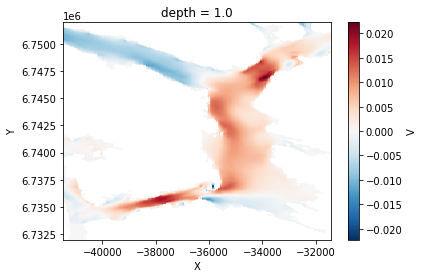

In [14]:
res.V.isel(mode=0).unstack('z').plot()

In [15]:
res['usvd']=(('time','z'),res.A.data@res.U.data.T)
res['vsvd']=(('time','z'),res.B.data@res.V.data.T)
res['u']=u
res['v']=v
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375, mode: 20)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -5.331e-11 -1.043e-07 ... -5.688e-05 0.0007158
    V        (z, mode) float32 3.949e-11 1.327e-07 ... -0.001661 0.001987
    L        (mode) float32 3.316e+04 1.923e+04 1.392e+04 ... 518.8 446.3 431.8
    A        (time, mode) float32 10.33 3.136 3.11 ... -0.1707 0.3819 -0.1089
    B        (time, mode) float32 7.25 4.125 0.3916 ... 0.1938 0.4367 -1.181
    usvd     (time, z) float32 -1.058e-05 -6.445e-07 ... -0.0269 -0.007757
    vsvd     (time, z) float32 4.598e-07 -1.591e-07 ... 0.05575 -0.005245
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04315 -0.02562 -0.007379
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.03503 0.03074 0.01637

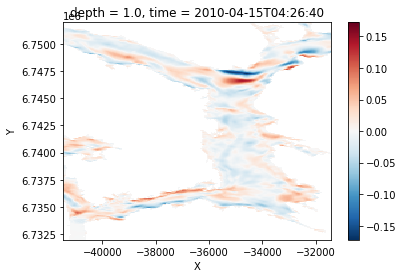

In [17]:
(res.usvd-res.u).isel(time=250).unstack('z').plot()

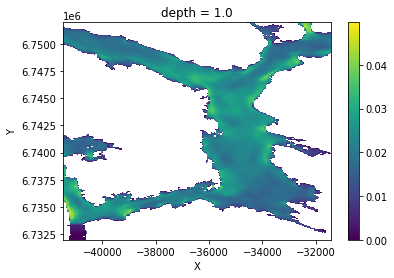

In [19]:
(res.vsvd-res.v).std(dim='time').unstack('z').plot()

In [18]:
res[['A','B','U','V']].unstack('z').to_netcdf('test.nc')

In [19]:
res[['u','v']].unstack('z').to_netcdf('testu.nc')

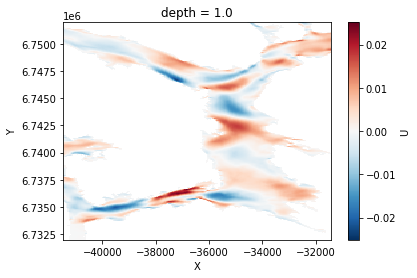

In [41]:
res.U.isel(mode=9).unstack('z').plot()

In [16]:
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375, mode: 20)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -5.331e-11 -1.043e-07 ... -5.688e-05 0.0007158
    V        (z, mode) float32 3.949e-11 1.327e-07 ... -0.001661 0.001987
    L        (mode) float32 3.316e+04 1.923e+04 1.392e+04 ... 518.8 446.3 431.8
    A        (time, mode) float32 10.33 3.136 3.11 ... -0.1707 0.3819 -0.1089
    B        (time, mode) float32 7.25 4.125 0.3916 ... 0.1938 0.4367 -1.181
    usvd     (time, z) float32 -1.058e-05 -6.445e-07 ... -0.0269 -0.007757
    vsvd     (time, z) float32 4.598e-07 -1.591e-07 ... 0.05575 -0.005245
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04315 -0.02562 -0.007379
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.03503 0.03074 0.01637

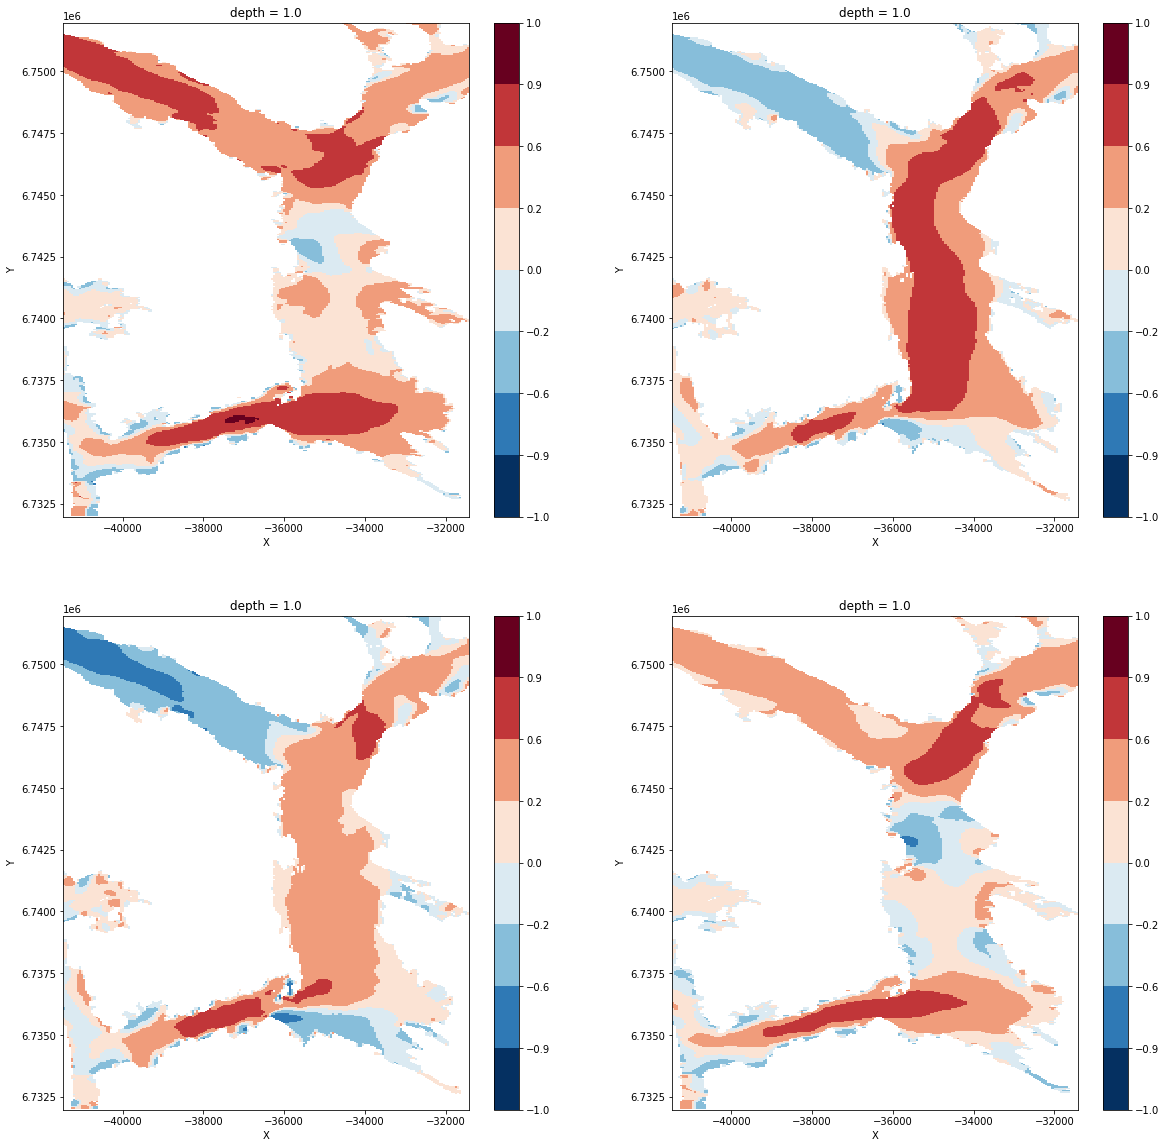

In [21]:
tmp=res.isel(mode=0)
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(20,20))
levels=[-1,-0.9,-0.6,-0.2,0,0.2,0.6,0.9,1]
xr.corr(tmp.A,tmp.u,dim='time').unstack('z').plot(ax=axes[0,0],levels=levels)
xr.corr(tmp.B,tmp.v,dim='time').unstack('z').plot(ax=axes[0,1],levels=levels)
xr.corr(tmp.A,tmp.v,dim='time').unstack('z').plot(ax=axes[1,0],levels=levels)
xr.corr(tmp.B,tmp.u,dim='time').unstack('z').plot(ax=axes[1,1],levels=levels)

In [22]:
L

array([33159.09   , 19231.705  , 13921.857  ,  8388.717  ,  3068.6611 ,
        2220.3418 ,  1879.5763 ,  1426.6063 ,  1124.3937 ,  1029.1638 ,
         900.447  ,   882.96   ,   786.5387 ,   731.63086,   646.8675 ,
         569.4411 ,   538.9147 ,   518.8396 ,   446.2731 ,   431.7546 ],
      dtype=float32)

## Time series

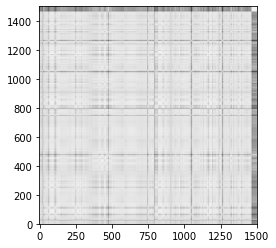

In [72]:
ts=res.A.isel(mode=0).data.reshape(1, -1)
rcp=RecurrencePlot()
#ts_new=rcp.fit(ts.data.T)
ts_new=rcp.transform(ts)
trsh=np.percentile(
    np.reshape(ts_new,(1501,-1)),
    np.arange(1,100),axis=1
    )
trsh.size
plt.imshow(ts_new[0],cmap='binary',origin='lower')

In [17]:
ts=res.A.data.T
np.shape(ts)

(20, 1501)

In [120]:
help(ssa.fit_transform)

Help on method fit_transform in module pyts.base:

fit_transform(X, y=None, **fit_params) method of pyts.decomposition.ssa.SingularSpectrumAnalysis instance
    Fit to data, then transform it.
    
    Fits transformer to `X` and `y` with optional parameters `fit_params`
    and returns a transformed version of `X`.
    
    Parameters
    ----------
    X : array-like, shape = (n_samples, n_timestamps)
        Univariate time series.
    
    y : None or array-like, shape = (n_samples,) (default = None)
        Target values (None for unsupervised transformations).
    
    **fit_params : dict
        Additional fit parameters.
    
    Returns
    -------
    X_new : array
        Transformed array.



In [18]:
from pyts.decomposition import SingularSpectrumAnalysis
ssa=SingularSpectrumAnalysis()#window_size=3)
X_ssa=ssa.fit_transform(ts)

In [127]:
np.shape(X_ssa)

(20, 4, 1501)

(300.0, 450.0)

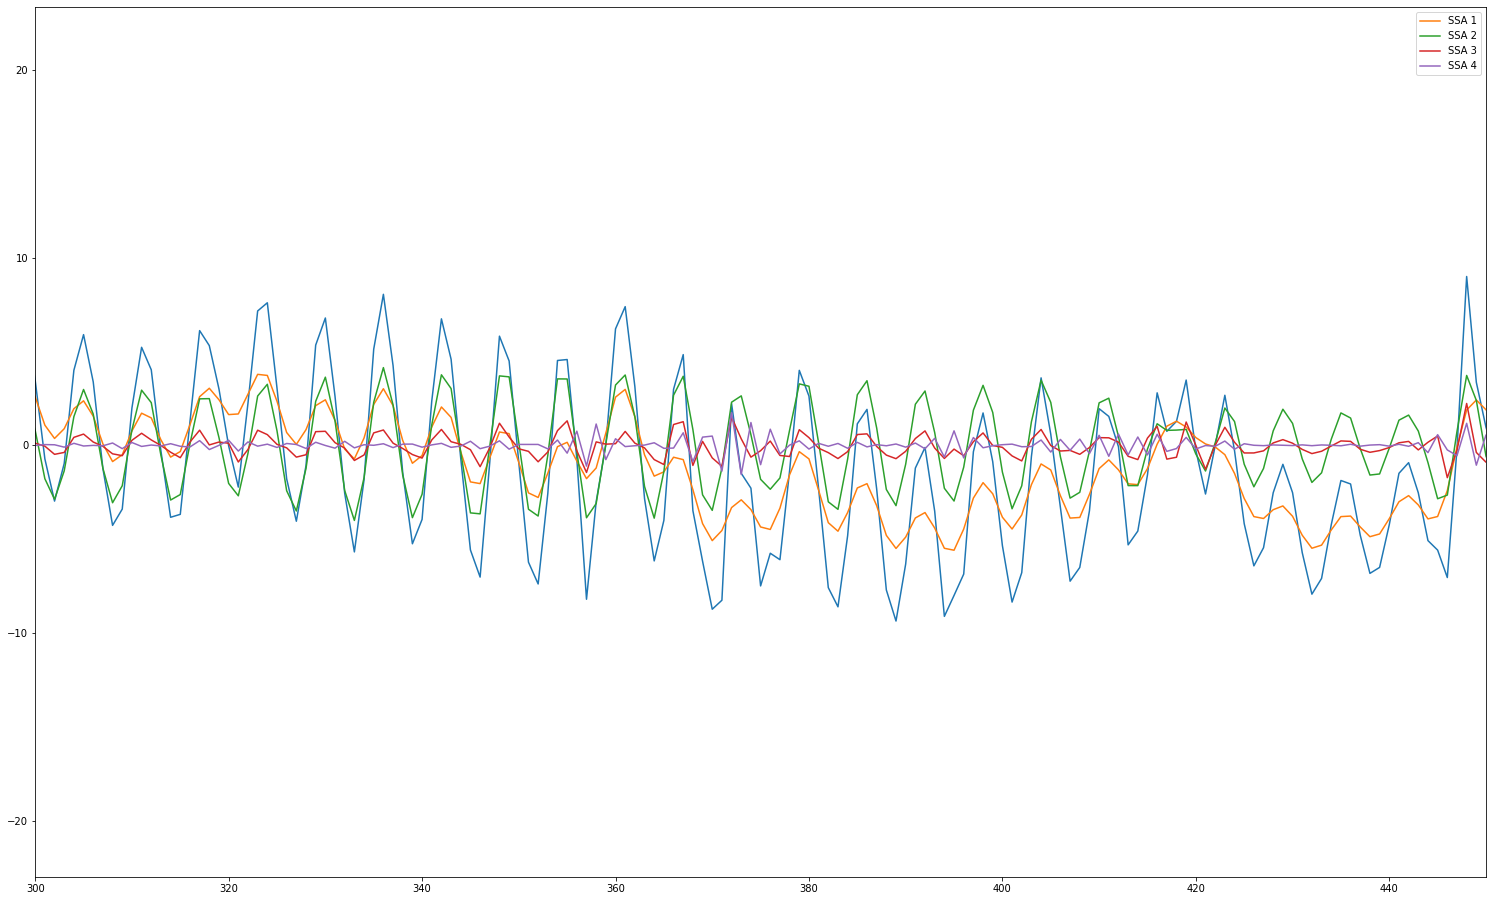

In [19]:
from cProfile import label


plt.figure(figsize=(26,16))
ax1=plt.subplot(111)
ax1.plot(ts[0])
plt.xlim(300,450)
ax2=plt.subplot(111)
for i in range(np.shape(X_ssa)[1]):
    ax2.plot(X_ssa[0,i,:],label='SSA {0}'.format(i+1))
ax2.legend(loc='best')
plt.xlim(300,450)

In [21]:
res.isel(mode=0)

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Data variables:
    U        (z) float32 -5.331e-11 -1.074e-13 6.134e-14 ... 0.0004857 0.0001407
    V        (z) float32 3.949e-11 6.703e-14 4.897e-17 ... -0.003026 -0.001298
    L        float32 3.316e+04
    A        (time) float32 10.33 8.738 3.418 -2.617 ... -13.59 -16.11 -17.61
    B        (time) float32 7.25 6.979 4.223 1.694 ... -13.5 -15.64 -15.87
    usvd     (time, z) float32 -1.058e-05 -6.445e-07 ... -0.0269 -0.007757
    vsvd     (time, z) float32 4.598e-07 -1.591e-07 ... 0.05575 -0.005245
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04315 -0.02562 -0.007379
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.03503 0.03074 0.01637

<AxesSubplot:>

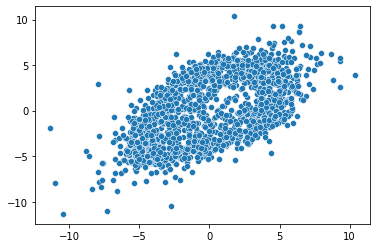

In [34]:
mode=1
sns.scatterplot(x=res.isel(mode=mode).A.data,y=res.isel(mode=mode).A.shift(time=1).data)

In [39]:
from pyts.bag_of_words import BagOfWords
ts=res.A.isel(mode=0).data.reshape(1, -1)
bow=BagOfWords()
ts_bow=bow.transform(ts)


In [42]:
from pyts.classification import LearningShapelets
clf=LearningShapelets()
clf.fit(ts)

TypeError: fit() missing 1 required positional argument: 'y'

In [43]:
from pyts.approximation import DiscreteFourierTransform
dft=DiscreteFourierTransform(n_coefs=10)
ts_dft=dft.fit_transform(ts)

In [45]:
ts_dft

array([[-3.70107591e-05, -7.80602026e+01,  2.94103791e+02,
        -9.90119548e+01, -5.26587525e+02, -9.55641559e+02,
        -4.56565304e+02, -4.94915501e+02, -2.92294268e+02,
         2.63048024e+02]])

In [51]:
import pywt
wavelt=pywt.dwt(ts,'haar')
np.shape(wavelt)

(2, 1, 751)

## Cross corr fine-coarse

In [74]:
HRdata=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

Text(0.5, 1.0, 'Standard deviation v velocity')

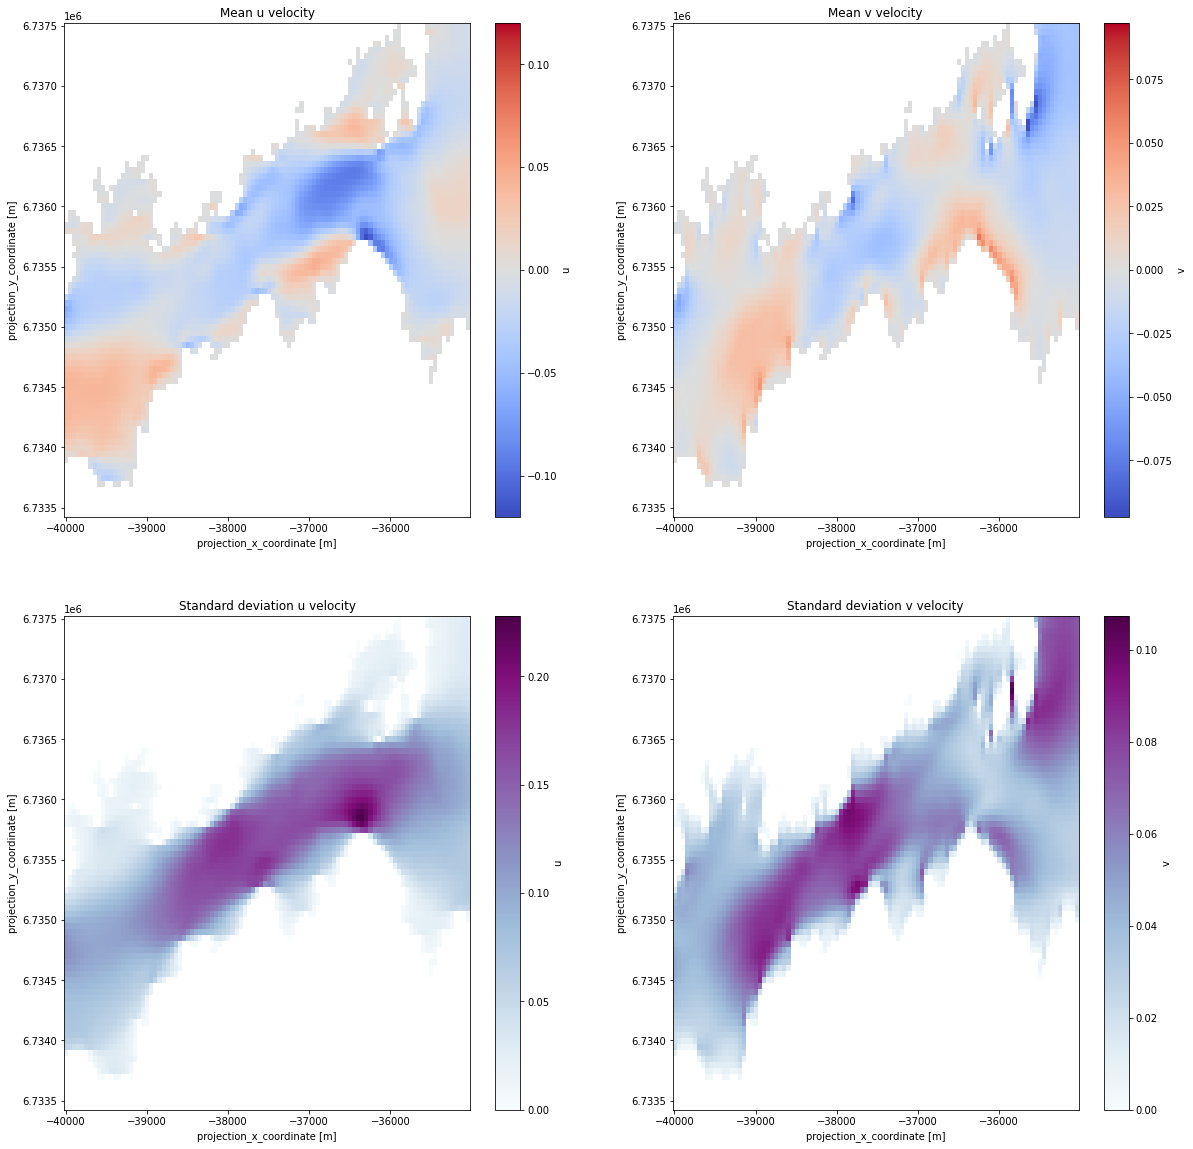

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
HRdata.u.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
HRdata.v.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
HRdata.u.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
HRdata.v.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [76]:
yname='Y'
xname='X'
skip=6
LRdata=HRdata.isel(Y=slice(0,HRdata.dims[yname],skip),X=slice(0,HRdata.dims[xname],skip))

Text(0.5, 1.0, 'Standard deviation v velocity')

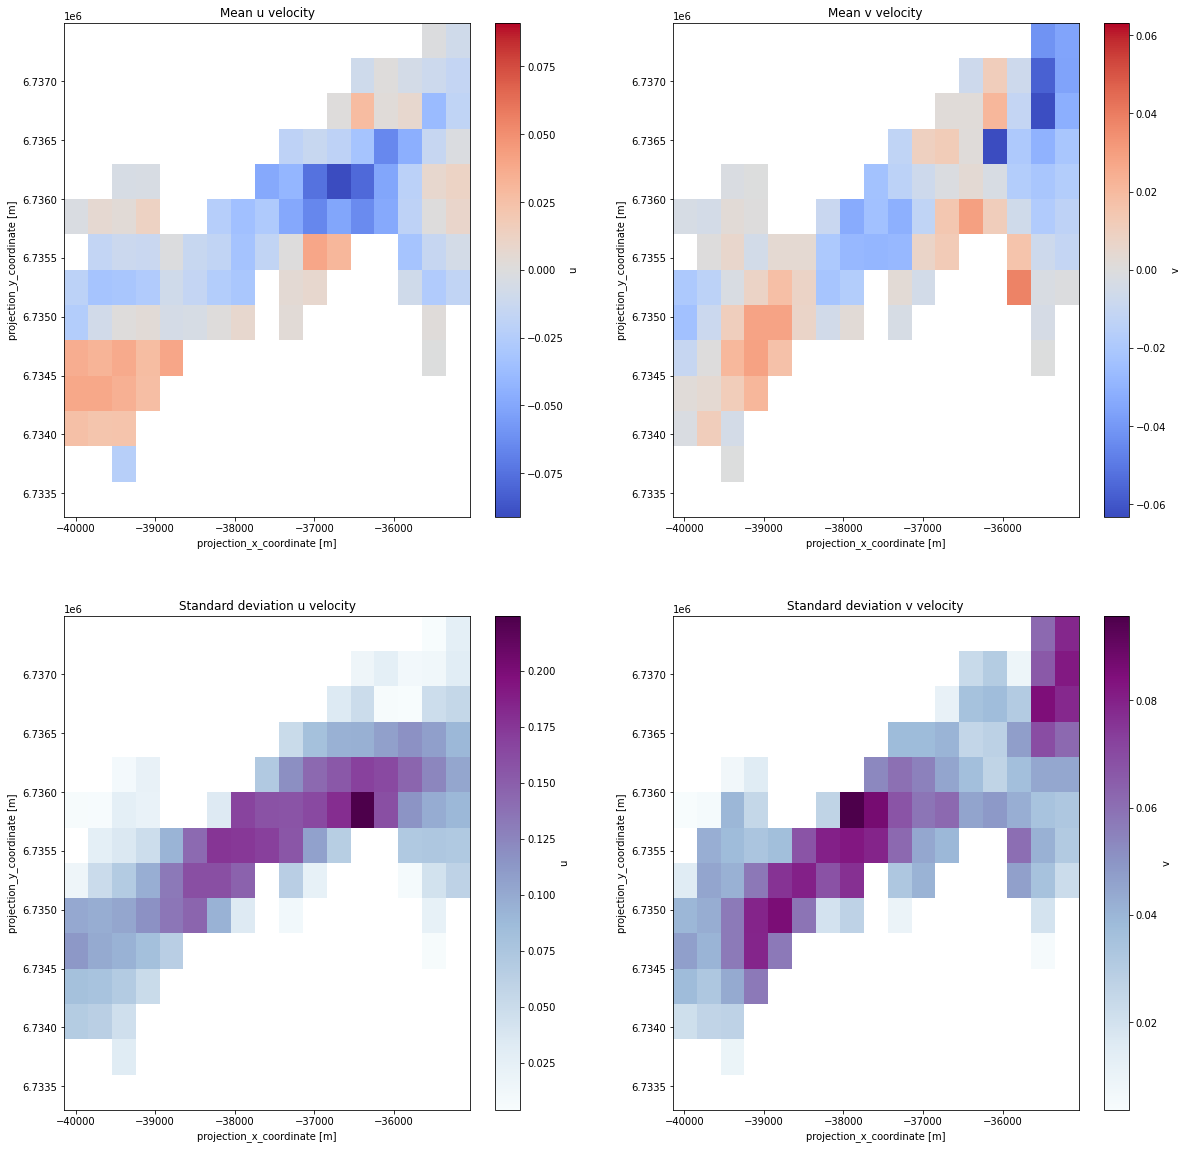

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
LRdata.u.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
LRdata.v.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
LRdata.u.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
LRdata.v.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [78]:
def create_vel(data):
    data['vel']=xr.concat([data['u'],data['v']] ,dim='comp')
    data=data.stack(z=['comp','Y','X'])
    data=data.where(data.land_binary_mask==0,drop=True).dropna(dim='time')
    return data

def norm_vel(data):
    out=((data-data.mean(dim='time')))#/data.std(dim='time'))
    return out.dropna(dim='z')
#LRvel=xr.concat([LRdata['u'],LRdata['v']] ,dim='comp')

In [79]:
HRvel=create_vel(HRdata)['vel']
LRvel=create_vel(LRdata)['vel']

In [80]:
HRnorm=norm_vel(HRvel)
LRnorm=norm_vel(LRvel)

In [81]:
LRvel

<xarray.DataArray 'vel' (time: 1501, z: 196)>
array([[-0.0551476 ,  0.01174853,  0.03578741, ...,  0.08330455,
         0.04893956,  0.0587655 ],
       [-0.03705893,  0.00864483,  0.0177404 , ...,  0.02797446,
        -0.03271115,  0.01471524],
       [-0.04463166, -0.06056198, -0.04702141, ..., -0.08073766,
        -0.10956556, -0.05944214],
       ...,
       [-0.03264773, -0.06113115, -0.064557  , ..., -0.36713946,
        -0.24694295, -0.3555003 ],
       [-0.02868588,  0.03920212, -0.02433619, ..., -0.34373873,
        -0.24446808, -0.32651347],
       [-0.00799333,  0.16502129,  0.12401505, ..., -0.32733768,
        -0.21551655, -0.29502633]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - comp     (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
  - Y        (z) float64 6.734e+06 6.734e+06 6.734e+06 ... 6.737e+06 6.737e+06
  - X        (z) float64 -3.939e+04 -3.999e+04 ... -3.549e+04 -3.519e+04
Attributes:
    units:          meter second-1
    time:           ocean_time
    field:          u-velocity, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water x velocity
    standard_name:  x_sea_water_velocity

In [82]:
C=(1/1500)*HRnorm.data.T@LRnorm.data

In [83]:
U,L,Vt = np.linalg.svd(C)
V=Vt.T

U=U[:,0:10]
V=V[:,0:10]
L=L[0:10]

In [84]:
A=HRnorm.data@U
B=LRnorm.data@V

In [35]:
uf=xr.DataArray(A@U.T,coords=HRnorm.coords)
vf=xr.DataArray(B@V.T,coords=LRnorm.coords)


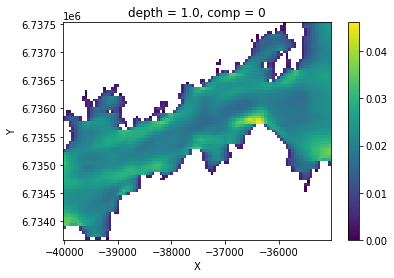

In [36]:
(uf-HRnorm).std(dim='time').unstack('z').isel(comp=0).plot()

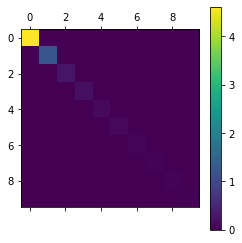

In [30]:
plt.matshow((A-A.mean(axis=0)).T@(B-B.mean(axis=0))/1500)
plt.colorbar()

In [37]:
U

array([[ 3.83895440e-06,  4.03594808e-04,  6.39574195e-04, ...,
         3.11101496e-04,  9.08863265e-04, -9.24636988e-05],
       [-6.21268964e-06,  4.16153111e-04,  6.70103298e-04, ...,
         2.99452571e-04,  8.01909948e-04, -1.09693676e-04],
       [ 2.53232865e-04,  2.28864650e-04, -1.06060717e-04, ...,
        -8.76659062e-04,  3.20902363e-05,  1.19864219e-03],
       ...,
       [-8.14827252e-03,  1.85044727e-03, -3.31741832e-02, ...,
         1.03231436e-02,  3.96297267e-03,  1.85171738e-02],
       [-7.98618887e-03,  2.50808639e-03, -3.10624707e-02, ...,
         8.11454374e-03,  5.49258804e-03,  2.06322763e-02],
       [-7.79969990e-03,  2.91161239e-03, -2.87246201e-02, ...,
         5.75634837e-03,  5.75837260e-03,  2.17000842e-02]], dtype=float32)